In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import mplleaflet

In [19]:
from route_shape_process_scripts import *
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
import time
import pandas as pd
import math
import multiprocessing
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, MultiLineString
import boto3
import io

# import gtfs

In [5]:
full_routes_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_routes_2018-08-15_2018-12-12.csv")
full_shapes_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_shapes_2018-08-15_2018-12-12.csv")
full_trips_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_trips_2018-08-15_2018-12-12.csv")
full_trip_stop_schedule = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_2018-08-15_2018-12-12.csv")

/Users/benjaminmalnor/anaconda2/envs/geopy36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                full_routes_gtfs.route_id.tolist()))

In [94]:
route_of_interest = "41"
direction_of_interest = 1
input_dict = {}
route_id = route_name_to_id_dict[route_of_interest]
shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, route_id, direction_of_interest)

In [95]:
base_key = "route_shape_files/raw/"
route_specific_key = "route_{}_{}_shape_{}".format(route_of_interest, 
                                                                 "".join(trip_headsign.replace("/","-").split(" ")),
                                                                        shape_id)
key_timeframe = "_raw_w_nearest_2018-08-15_2018-12-11.csv"
file_key = base_key+route_specific_key+key_timeframe
file_key

'route_shape_files/raw/route_41_DowntownSeattleNorthgate_shape_20041006_raw_w_nearest_2018-08-15_2018-12-11.csv'

# Import file from S3

In [96]:
s3 = boto3.client("s3")
bucket_name = "malnor.seattle.bustime"
s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))

# we need to grab the shape_pt_sequence and so we can match shape_pt_sequence with shape_dist_traveled TODO: make add this field earlier in the position join

In [97]:
one_shape = full_shapes_gtfs[(full_shapes_gtfs['shape_id']==shape_id)&\
                            (full_shapes_gtfs['start_gtfs_date']=='2018-08-15')&\
                            (full_shapes_gtfs['end_gtfs_date']=='2018-09-23')]
one_shape.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,start_gtfs_date,end_gtfs_date
145225,20041006,47.722698,-122.291702,1,0.0,2018-08-15,2018-09-23
145226,20041006,47.722732,-122.291992,2,70.3,2018-08-15,2018-09-23
145227,20041006,47.722897,-122.292999,3,326.1,2018-08-15,2018-09-23
145228,20041006,47.722897,-122.293190,4,373.7,2018-08-15,2018-09-23
145229,20041006,47.722668,-122.293312,5,463.8,2018-08-15,2018-09-23


In [98]:
unpacked_positions_full = unpacked_positions_full.merge(one_shape[['shape_pt_sequence','shape_dist_traveled']],how='left', on='shape_pt_sequence' )

In [99]:
def make_geopandas_shape_df(gtfs_shapes, shape_id):
    '''
    INPUT
    -------
    gtfs_shapes = gtfs shapes.txt file dataframe
    shape_id = one shape_id to filter on
    OUTPUT
    -------
    route_vertex_geo <-- geopandas version of a particular schedule shapes.txt geometry = route vertex points
    '''
    one_shape_df = gtfs_shapes[gtfs_shapes['shape_id'] == shape_id].copy()
    crs = {'init':'epsg:4326'}
    shape_geometry = [Point(xy) for xy in zip(one_shape_df.shape_pt_lon, one_shape_df.shape_pt_lat)]
    route_vertex_geo = GeoDataFrame(one_shape_df, crs=crs, geometry=shape_geometry)
    return route_vertex_geo

In [100]:
route_shape_vertex = make_geopandas_shape_df(full_shapes_gtfs, shape_id)

In [101]:
def datetime_transform_df(df):
    '''
    '''
    df['time_pct'] = df['time_utc'].apply(pd.to_datetime)
    df.set_index('time_pct', inplace=True)
    df.sort_index(inplace=True)
    df = df.tz_localize('UTC')
    df = df.tz_convert('US/Pacific')
    
    return df

In [102]:
unpacked_positions_full = datetime_transform_df(unpacked_positions_full)

In [103]:
unpacked_positions_full[['month_day_trip_veh','timestamp',
                                 'vehicle_lat','vehicle_long',
                                 'shape_pt_sequence','shape_dist_traveled'
                               ]].head(5)

,month_day_trip_veh,timestamp,vehicle_lat,vehicle_long,shape_pt_sequence,shape_dist_traveled
time_pct,,,,,,
2018-09-22 05:48:18-07:00,2018_9_22_39686550_6908,1537620498,47.722801,-122.292412,2,70.3
2018-09-22 05:49:48-07:00,2018_9_22_39686550_6908,1537620588,47.722633,-122.293327,5,463.8
2018-09-22 05:51:18-07:00,2018_9_22_39686550_6908,1537620678,47.719280,-122.295784,9,1921.6
2018-09-22 05:52:48-07:00,2018_9_22_39686550_6908,1537620768,47.719318,-122.302299,20,3513.8
2018-09-22 05:54:17-07:00,2018_9_22_39686550_6908,1537620857,47.719437,-122.313156,34,6191.8


In [104]:
def get_travel_rate(row):
    ##shape dist traveled is in feet, time in seconds travel_rate_update mph
    travel_rate = (row['shape_dist_diff']/row['total_seconds_delta'])*(5280)*(1/(60*60))
    return travel_rate

In [105]:
def get_distance_time_parallel(df):
    '''
    '''
    df.sort_index(inplace=True)
    df.loc[:,'shape_dist_diff'] = df.loc[:,'shape_dist_traveled'].diff(1)
    df.loc[:,'time_delta'] = df.index.to_series().diff(1)
    
    df['shape_pt_seq_tuple'] = list(zip(df.shift(1).apply(lambda x: 9999 if math.isnan(x['shape_pt_sequence']) else int(x['shape_pt_sequence']), axis=1).values,
                            df.apply(lambda x: x['shape_pt_sequence'], axis=1).values))
    
    df.dropna(axis=0, how='any', subset=['time_delta','shape_dist_diff'], inplace=True)
    
    df.loc[:,'total_seconds_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
    
    if df.empty:
        pass
    else:
        df.loc[:,'travel_rate_mph'] = df.apply(get_travel_rate, axis=1)

    return df

In [106]:
def get_distance_time_diffs(unpacked_positions_full):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    distance_time_list = []
    grouped =  unpacked_positions_full.groupby('month_day_trip_veh')
    for name, group in grouped:
        distance_time_list.append(group)
    distance_time_list_df = pd.concat(pool.map(get_distance_time_parallel, distance_time_list))
    return distance_time_list_df

# below starts the 'get_distance_time_diffs' function - if you have a windows I don't think this will work... just run it without multiprocessing

In [107]:
if __name__ == "__main__":
    start = time.time()
    distance_time_list_df = get_distance_time_diffs(unpacked_positions_full)
    end = time.time()
    print(end - start)

35.42965316772461


# flag all trip segments with travel_rate < threshold 

In [108]:
mph_rate_flag = 10 #can change
new_df = distance_time_list_df.copy()
new_df['trouble_flag'] = new_df.apply(lambda x: True if x['travel_rate_mph'] < mph_rate_flag else False, axis=1)

# isolate only the bad segments :)

In [109]:
new_df_true = new_df[new_df['trouble_flag'] == True]

In [110]:
new_df_true.reset_index(inplace=True)

In [111]:
new_df_true.head(3)

,time_pct,day,direction_id,dist_to_nearest_route_pt,dow,geometry,hour,month,month_day_trip_veh,near_node_pt,...,time_utc,timestamp,total_seconds_delta,travel_rate_mph,trip_id,vehicle_id,vehicle_lat,vehicle_long,year,trouble_flag
0,2018-10-10 17:18:44-07:00,10,1,0.000024,2,POINT (-122.2933197021484 47.7226448059082),17,10,2018_10_10_39682688_6897,"(-122.293312, 47.7226677)",...,2018-10-11 00:18:44,1539217124,90.0,7.558222,39682688,6897,47.722645,-122.293320,2018,True
1,2018-10-10 17:32:14-07:00,10,1,0.000017,2,POINT (-122.3232650756836 47.70817947387695),17,10,2018_10_10_39682688_6897,"(-122.323273, 47.70819470000001)",...,2018-10-11 00:32:14,1539217934,180.0,4.730815,39682688,6897,47.708179,-122.323265,2018,True
2,2018-10-10 17:38:15-07:00,10,1,0.000065,2,POINT (-122.3271408081055 47.70196533203125),17,10,2018_10_10_39682688_6897,"(-122.327148, 47.7020302)",...,2018-10-11 00:38:15,1539218295,270.0,7.035654,39682688,6897,47.701965,-122.327141,2018,True


In [112]:
def get_all_segments_parallel(row):
    '''
    '''
    col_list = ['month_day_trip_veh',
                'trip_hour',
               'time_pct',
               'trip_dow',
               'travel_rate_mph',
                'pt_seq',
               'real_obv',
               'trouble_spot_flag']
    edge_for_upload = []
    month_day_trip_veh = row['month_day_trip_veh']
    trip_hour = row['hour']
    time_pct = row['time_pct']
    trip_dow = row['dow']
    travel_rate_mph = row['travel_rate_mph']
    
    pt_seq_start = row['shape_pt_seq_tuple'][0]
    pt_seq_end = row['shape_pt_seq_tuple'][1]
    full_edge_df = pd.DataFrame()
    for idx, pt_seq in enumerate(range(pt_seq_start,pt_seq_end)):
        if idx == 0:
            real_obv = True
        else:
            real_obv = False
        trouble_spot = 1
        info_tuple = (month_day_trip_veh,
                     trip_hour,
                     time_pct,
                     trip_dow,
                     travel_rate_mph,
                      pt_seq,
                     real_obv,
                     trouble_spot)
        edge_for_upload.append(info_tuple)
        edge_df = pd.DataFrame(edge_for_upload, columns=col_list)

        
        if full_edge_df.empty:
            full_edge_df = edge_df.copy()
        else:
            full_edge_df = full_edge_df.append(edge_df)
    return full_edge_df

In [113]:
def get_segments(new_df_true):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    row_list = []
    for index, row in new_df_true.iterrows():
        row_list.append(row)
    full_edge_df = pd.concat(pool.map(get_all_segments_parallel, row_list))
    return full_edge_df

In [114]:
if __name__ == "__main__":
    start = time.time()
    full_edge_df = get_segments(new_df_true)
    end = time.time()
    print(end - start)

76.04532480239868


In [115]:
full_edge_df.head()

,month_day_trip_veh,trip_hour,time_pct,trip_dow,travel_rate_mph,pt_seq,real_obv,trouble_spot_flag
0,2018_10_10_39682688_6897,17,2018-10-10 17:18:44-07:00,2,7.558222,1,True,1
0,2018_10_10_39682688_6897,17,2018-10-10 17:18:44-07:00,2,7.558222,1,True,1
1,2018_10_10_39682688_6897,17,2018-10-10 17:18:44-07:00,2,7.558222,2,False,1
0,2018_10_10_39682688_6897,17,2018-10-10 17:18:44-07:00,2,7.558222,1,True,1
1,2018_10_10_39682688_6897,17,2018-10-10 17:18:44-07:00,2,7.558222,2,False,1


# export results - need to find an appropriate place / way to store this info

In [116]:
full_edge_df.to_csv('route_{}_shape_{}_slowspots_2018-08-15_2018-12-11.csv'.format(
                                        route_id, shape_id), index=True)

In [117]:
route_shape_vertex.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,start_gtfs_date,end_gtfs_date,geometry
145225,20041006,47.722698,-122.291702,1,0.0,2018-08-15,2018-09-23,POINT (-122.291702 47.7226982)
145226,20041006,47.722732,-122.291992,2,70.3,2018-08-15,2018-09-23,POINT (-122.291992 47.7227325)
145227,20041006,47.722897,-122.292999,3,326.1,2018-08-15,2018-09-23,POINT (-122.292999 47.7228966)
145228,20041006,47.722897,-122.293190,4,373.7,2018-08-15,2018-09-23,POINT (-122.29319 47.7228966)
145229,20041006,47.722668,-122.293312,5,463.8,2018-08-15,2018-09-23,POINT (-122.293312 47.7226677)


# match shape_pt_sequence to stops

In [118]:
grouped_trips = full_trip_stop_schedule.groupby(['start_gtfs_date','end_gtfs_date'])
day_trips = grouped_trips.get_group(('2018-09-24', '2018-09-24'))
shape_trips = day_trips[(day_trips['shape_id']==shape_id)]
route_shape_w_names = route_shape_vertex.merge(shape_trips[['stop_sequence','stop_name']], 
                                               how='left', left_on='shape_pt_sequence',
                                              right_on='stop_sequence')

In [119]:
route_shape_w_names = route_shape_w_names.drop_duplicates(subset='stop_sequence', keep='first')\
                        .copy()

In [120]:
route_shape_w_names = route_shape_w_names[route_shape_w_names.stop_sequence.notnull()].copy()

In [121]:
stop_name_dict = pd.Series(data=route_shape_w_names.stop_name.values,
          index=route_shape_w_names.shape_pt_sequence.values).to_dict()

In [122]:
morning_hours = [7,8,9]
afternoon_hours = [15,16,17,18]
peak_hours = morning_hours+afternoon_hours
all_hours = list(full_edge_df.trip_hour.unique())
offpeak_hours = [hours for hours in all_hours if hours not in peak_hours]

# all hours

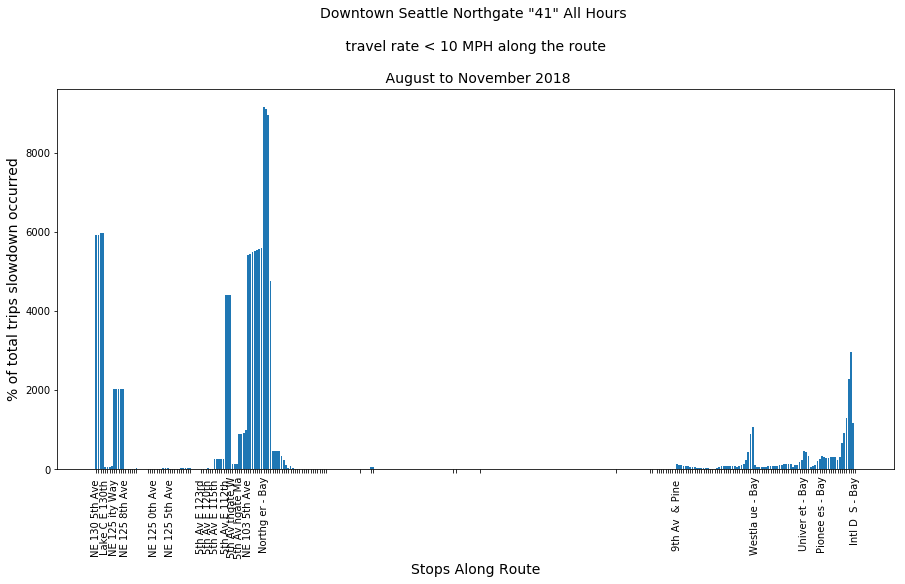

In [123]:
total_trips = len(full_edge_df.month_day_trip_veh.unique())
pivot_sums = full_edge_df.pivot_table(values='trouble_spot_flag', 
                                      index='month_day_trip_veh', 
                                      columns='pt_seq')\
                                        .sum(axis=0)*100/total_trips
# GET LABELS
###################
x_labels = []
for idx_num in pivot_sums.index:
    if idx_num in stop_name_dict.keys():
        idx_num_label = str(stop_name_dict[idx_num])
        label_str = idx_num_label[:6]+" "+idx_num_label[-10:-2]
        x_labels.append(label_str)
    else:
        x_labels.append("")
###################
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values*100
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" All Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest))
_ = ax.set_title(title_str, fontsize=14)

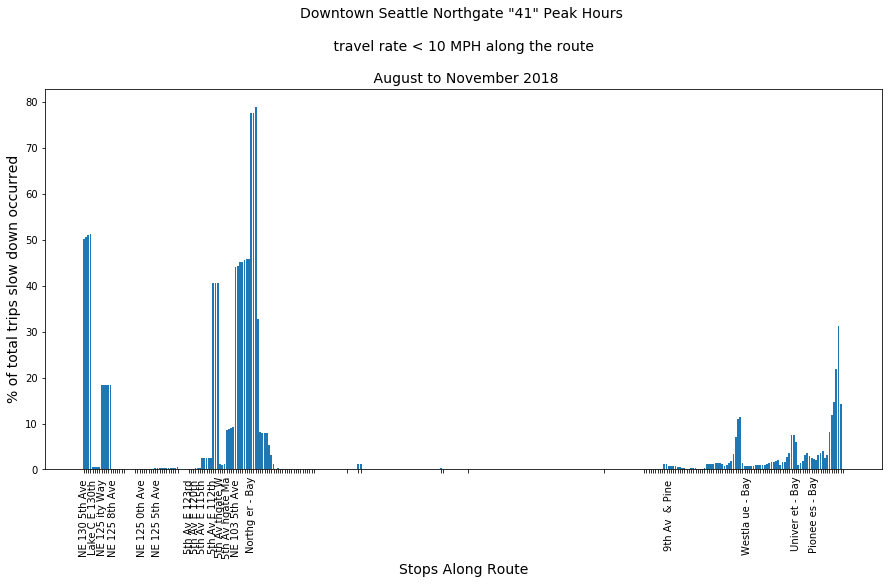

In [124]:
total_trips = len(full_edge_df[full_edge_df['trip_hour'].isin(peak_hours)]\
                                                          .month_day_trip_veh.unique())
pivot_sums = full_edge_df[full_edge_df['trip_hour'].isin(peak_hours)]\
                                                    .pivot_table(values='trouble_spot_flag', 
                                                                  index='month_day_trip_veh', 
                                                                  columns='pt_seq')\
                                                    .sum(axis=0)/total_trips
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values*100
ax.bar(x_pos, bar_h)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.set_ylabel("% of total trips slow down occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Peak Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest))
_ = ax.set_title(title_str, fontsize=14)

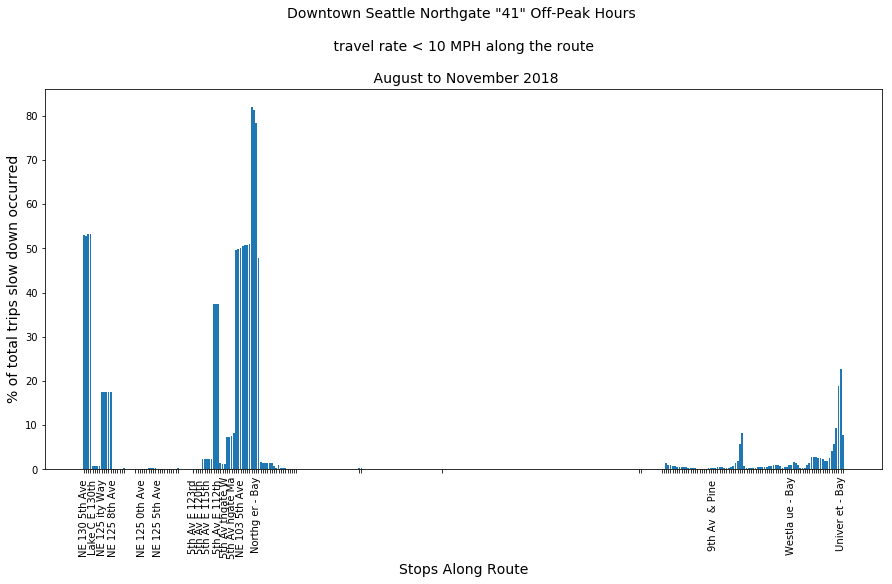

In [125]:
total_trips = len(full_edge_df[full_edge_df['trip_hour'].isin(offpeak_hours)]\
                                                          .month_day_trip_veh.unique())
pivot_sums = full_edge_df[full_edge_df['trip_hour'].isin(offpeak_hours)]\
                                                    .pivot_table(values='trouble_spot_flag', 
                                                                 index='month_day_trip_veh', 
                                                                 columns='pt_seq')\
                                                    .sum(axis=0)/total_trips
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values*100
ax.bar(x_pos, bar_h)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.set_ylabel("% of total trips slow down occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Off-Peak Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest))
_ = ax.set_title(title_str, fontsize=14)

In [126]:
full_edge_counts = full_edge_df.groupby('pt_seq').agg({'trouble_spot_flag':'sum'})\
    .reset_index()

In [127]:
route_with_counts = route_shape_vertex.merge(full_edge_counts, how='left', left_on='shape_pt_sequence', right_on='pt_seq')

In [128]:
route_with_counts.dropna(axis=0,how='any',subset=['trouble_spot_flag'], inplace=True)

# this leaflet widget does not always work for me

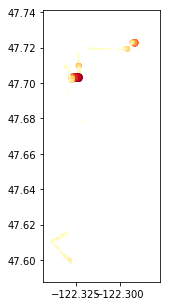

In [129]:
fig, ax = plt.subplots(figsize=(5,5))
route_with_counts.plot(ax=ax, column='trouble_spot_flag', 
                    cmap='YlOrRd',
                   markersize=route_with_counts['trouble_spot_flag'].values/200)

In [130]:
mplleaflet.show(fig=ax.figure,crs=route_with_counts.crs)

# save to geojson and view in QGIS or Tableau/PowerBI

In [66]:
route_with_counts_json = route_with_counts.to_json()
file_name = "route_{}_{}_{}_bad_speed_count.geojson".format(input_dict['route_id'],
                                                         input_dict['shape_id'], 
                                                         trip_sign)
with open(file_name, "w") as f:
    f.write(route_with_counts_json)

In [81]:
import requests
api_key = os.environ["ONEBUSAWAY_KEY"]

In [86]:
agency = '1'  # this is the agency ID for King County Metro
base_url = 'http://pugetsound.onebusaway.org/api/'
endpoints = {'position': 'gtfs_realtime/vehicle-positions-for-agency/{agency}.json',
           'alert': 'gtfs_realtime/alerts-for-agency/{agency}.json',
           'update': 'gtfs_realtime/trip-updates-for-agency/{agency}.json'}

In [87]:
def single_request(url, api_key):
    params = {'key': api_key}
    r = requests.get(url,params=params)
    try:
        if r.status_code == 200:
            return r.content
    except:
        logging.error('status code {}'.format(r.status_code))

In [88]:
url = base_url + endpoints['position'].format(agency=agency)
api_content = single_request(url, api_key)

In [91]:
api_key

'02c542c2-023d-47c4-891c-bd22c8c2a552'

In [90]:
url

'http://pugetsound.onebusaway.org/api/gtfs_realtime/vehicle-positions-for-agency/1.json'